# Chemistry Lab 1 - Profiles
**Developed for the OOI Data Lab Notebook**

By Sage Lichtenwalner

Revised August 17, 2020

This notebook is based on the prototype [notebook](https://github.com/ooi-data-lab/data-lab-workshops/blob/master/March2019/Activities/DL_March_Profiles_v2_Final.ipynb) developed for the *Ocean Profiles* Data Exploration.

In [ ]:
# Notebook setup
import requests
import os
import re
import xarray as xr
!pip install netcdf4
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Make the Plots pretty
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Load Data

The data for this activity comes from
* CP04OSPM-WFP01-03-CTDPFK000 (telemetered)

In [ ]:
url_ctd = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200813T045539781Z-CP04OSPM-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/catalog.html'

In [ ]:
def get_datalist(url):
  '''Return all the relevant .nc files from a specified OOI THREDDS url'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous data files if necessary
  catalog_rms = url.split('/')[-2][20:]
  selected_datasets = []
  for d in datasets:
    if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
      selected_datasets.append(d + '#fillmismatch') # Add #fillmismatch to the URL to deal with a bug
  selected_datasets = sorted(selected_datasets)
  return selected_datasets

In [ ]:
# List of data files
ctd_files = get_datalist(url_ctd)

In [ ]:
%%time
# Load the data files using xarray
ctd_data = xr.open_mfdataset(ctd_files).swap_dims({'obs': 'time'})
print('Dataset has %s points' % "{:,}".format(ctd_data.time.size))

Dataset has 3,889,811 points
CPU times: user 1.15 s, sys: 252 ms, total: 1.4 s
Wall time: 11.7 s


In [ ]:
# Clean Data
ctd_data['practical_salinity'] = ctd_data['practical_salinity'].where(ctd_data['practical_salinity']>32)

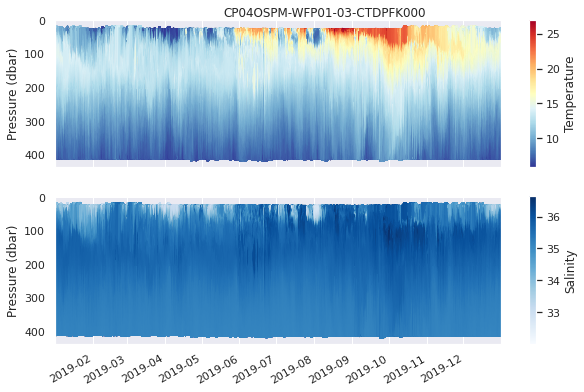

In [ ]:
# Quickplot
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,6))
sc1 = ax1.scatter(ctd_data.time, ctd_data.ctdpf_ckl_seawater_pressure, c=ctd_data.ctdpf_ckl_seawater_temperature, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(ctd_data.time, ctd_data.ctdpf_ckl_seawater_pressure, c=ctd_data.practical_salinity, cmap='Blues', s=2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(ctd_data.time[0],ctd_data.time[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
cbar.ax.set_ylabel('Salinity')

ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')

fig.suptitle('CP04OSPM-WFP01-03-CTDPFK000')
fig.autofmt_xdate()
fig.subplots_adjust(top=0.95);

fig.savefig('density_profiles1.png');


## Subset and Bin the Data

In [ ]:
# Day and Depth Binning Function
def bindata(vd,binvar):
  bins = np.arange(0, 420, 2) #Specify output depth bins here
  labels = (bins[:-1] + bins[1:])/2
  a = vd.groupby_bins(binvar,bins,labels=labels).mean(dim=xr.ALL_DIMS, skipna=True)
  return a

In [ ]:
# Tweak the depth variables for binning
ctd_data['pressure'] = ctd_data['ctdpf_ckl_seawater_pressure']
ctd_data['seawater_temperature'] = ctd_data['ctdpf_ckl_seawater_temperature']

In [ ]:
# Specify dates to process
dates = pd.date_range('2019-01-01', periods=12, freq='MS')
dates

DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
# Specify the variables we want
var_list_ctd = ['pressure','seawater_temperature','practical_salinity','density']

In [ ]:
# And now we do the depth binning for the selected dates
dsout = False
for d in dates:
  print(d)
  ds = ctd_data[var_list_ctd].sel(time=slice(d,d+pd.Timedelta('28 days'))).load()
  if ds.sizes['time'] > 0:
    dsr = ds.resample(time='1MS').apply(bindata,binvar='pressure')
    if(isinstance(dsout,xr.Dataset)):
      dsout = xr.concat([dsout, dsr],dim='time')
    else:
      dsout = dsr

2019-01-01 00:00:00
2019-02-01 00:00:00
2019-03-01 00:00:00
2019-04-01 00:00:00
2019-05-01 00:00:00
2019-06-01 00:00:00
2019-07-01 00:00:00
2019-08-01 00:00:00
2019-09-01 00:00:00
2019-10-01 00:00:00
2019-11-01 00:00:00
2019-12-01 00:00:00


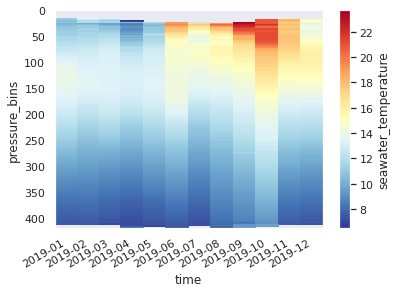

In [ ]:
# Quickplot
dsout.seawater_temperature.plot(x='time',y='pressure_bins',cmap='RdYlBu_r',yincrease=False);

In [ ]:
# Convert dataset
pldata = dsout.to_dataframe().reset_index()

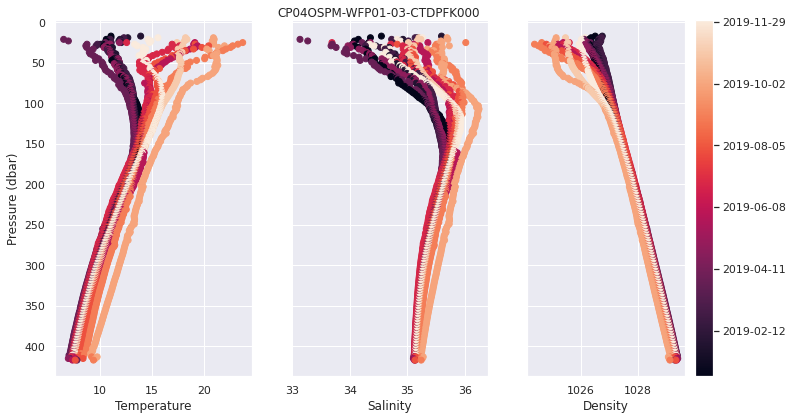

In [ ]:
# Plot the profiles
fig,(ax1,ax2,ax3) = plt.subplots(1,3, sharey=True, figsize=(12,6))
sc1 = ax1.scatter(pldata.seawater_temperature, pldata.pressure_bins, c=pldata.time);
ax1.set_xlabel('Temperature')
ax2.scatter(pldata.practical_salinity, pldata.pressure_bins, c=pldata.time);
ax2.set_xlabel('Salinity')
ax3.scatter(pldata.density, pldata.pressure_bins, c=pldata.time);
ax3.set_xlabel('Density')

ax1.invert_yaxis();
ax1.set_ylabel('Pressure (dbar)')

cbar = fig.colorbar(sc1, ax=ax3, orientation='vertical')
# Fix the colorbar ticks
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%Y-%m-%d'));

fig.suptitle('CP04OSPM-WFP01-03-CTDPFK000')
fig.subplots_adjust(top=0.95);

fig.savefig('density_profiles2.png');

In [ ]:
pldata.describe()

,pressure_bins,seawater_temperature,practical_salinity,density
count,2508.000000,2366.000000,2366.000000,2366.000000
mean,209.000000,11.867779,35.391020,1027.856811
std,120.688888,2.873640,0.334648,0.986865
min,1.000000,6.536935,33.138963,1024.361121
25%,105.000000,9.526446,35.196790,1027.208885
50%,209.000000,11.781059,35.382910,1027.966821
75%,313.000000,13.542339,35.618522,1028.660777
max,417.000000,23.687400,36.239643,1029.401054


In [ ]:
pldata.to_csv('density_profiles.csv')